In [1]:
#importing necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
#reading data
path_dir="data/YOLO_data/FullIJCNN2013/"

data = pd.read_csv(path_dir+'gt.txt',sep=';',names=['path','left','top','right','bottom','id'])
data.head()

,path,left,top,right,bottom,id
0,00000.ppm,774,411,815,446,11
1,00001.ppm,983,388,1024,432,40
2,00001.ppm,386,494,442,552,38
3,00001.ppm,973,335,1031,390,13
4,00002.ppm,892,476,1006,592,39


(800, 1360, 3)


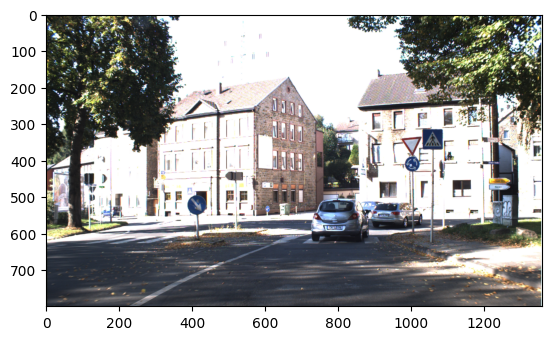

In [3]:
from PIL import Image
#opening image and converting it into numpy array and checking the size of array.
img = Image.open(path_dir+data['path'][0])
#img.show()
img=np.array(img)
print(img.shape)

img = Image.open(path_dir+data['path'][1])
img=np.array(img)
plt.imshow(img[:,:,:])

In [4]:
#checking size of all arrays
size=[]
for i in range(len(data)):
  img = Image.open(path_dir+data['path'][i])
  img=np.array(img)
  size.append(img.shape)

print(len(size))

1213


In [5]:
#converting all images to array representation to use it afterwards.
image_array=[]
for i in range(len(data)):
  img = Image.open(path_dir+data['path'][i])
  img=np.array(img)
  image_array.append(img)

In [6]:
data['id'].value_counts()

id
38    88
12    85
13    83
2     81
10    80
1     79
4     68
8     57
5     53
7     41
9     41
11    38
18    38
14    32
25    31
3     30
17    29
23    20
35    20
6     19
26    18
30    16
33    16
15    15
28    14
22    13
34    12
42    11
40    10
36     9
20     9
16     8
32     8
41     7
39     6
29     5
21     5
24     5
0      4
27     3
37     2
19     2
31     2
Name: count, dtype: int64

In [7]:
#copying id column of data into df
df = data['id'].copy()
data ['Object Name'] = data['id']
#assigning new labels, 1 implies prohibitory,2 implies danger,3 implies mandatory and 4 implies other.
for i in range(len(df)):
  if(df[i] in range(0,43)):
    df.loc[i]=0
    data['Object Name'].loc[i]='trafficsign'
  else:
    df.loc[i]=-1


data.head()

C:\Users\fgarcia24\AppData\Local\Temp\ipykernel_31132\470147318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Object Name'].loc[i]='trafficsign'


,path,left,top,right,bottom,id,Object Name
0,00000.ppm,774,411,815,446,11,trafficsign
1,00001.ppm,983,388,1024,432,40,trafficsign
2,00001.ppm,386,494,442,552,38,trafficsign
3,00001.ppm,973,335,1031,390,13,trafficsign
4,00002.ppm,892,476,1006,592,39,trafficsign


In [8]:
box_size=[]
for i in range(len(data)):
  bounding = data['bottom'][i]-data['top'][i]+data['right'][i]-data['left'][i]
  box_size.append(bounding)

max(box_size)

248

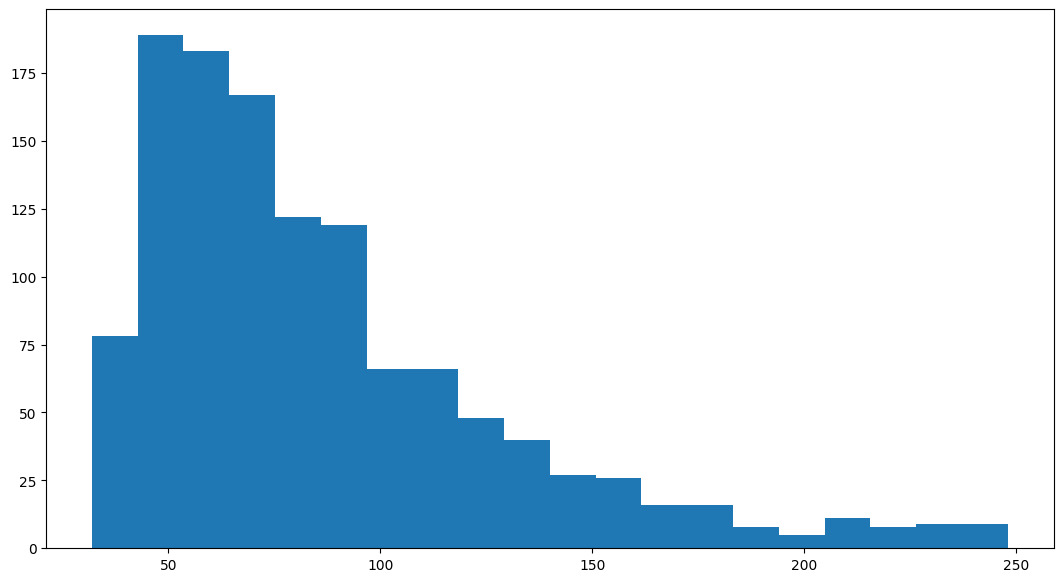

In [9]:
plt.figure(figsize=(13,7))
plt.hist(box_size, bins=20);

## Converting to jpg format and removing images without objects

In [10]:
#removing .ppm from path
data['path'] = data['path'].str.slice(0, -4)
data.head()

,path,left,top,right,bottom,id,Object Name
0,00000,774,411,815,446,11,trafficsign
1,00001,983,388,1024,432,40,trafficsign
2,00001,386,494,442,552,38,trafficsign
3,00001,973,335,1031,390,13,trafficsign
4,00002,892,476,1006,592,39,trafficsign


In [11]:
# Using os.walk for going through all directories
# and files in them from the current directory
import os
import cv2
path_dir="data/YOLO_data/FullIJCNN2013/"
final_df=pd.DataFrame(columns=data.columns)
df_list = [] # create an empty list of DataFrames
for current_dir, dirs, files in os.walk(path_dir):
    for f in files:
        #print(f)
        #Check if a file end with .ppm format or not
        if f.endswith('.ppm'):
            image_name=f[:-4]
            img=cv2.imread(path_dir + f)
            single_yolo_dat = data.loc[data['path'] == image_name].copy()
            #print(single_yolo_dat)
            # and, in this way, initial dataFrame will not be changed
            # Checking if there is no any annotations for current image
            if single_yolo_dat.isnull().values.all():
                # Removing this image from train data
                # print(f)
                os.remove(path_dir + f)
                
            #Now save the resulted_frame to a folder inside path_dir
            else:
              df_list.append(single_yolo_dat) # append to the list of DataFrames
              #Now writng and saving the image from ppm format to jpg format using OpenCV
              save_path = 'data/YOLO_data/jpeg_files/' + image_name + '.jpg'
              cv2.imwrite(save_path, img)

final_df = pd.concat(df_list) # concatenate the list of DataFrames
final_df = final_df[~final_df.index.duplicated(keep='first')]
final_df.sort_index(inplace=True)

In [12]:
final_df

,path,left,top,right,bottom,id,Object Name
0,00000,774,411,815,446,11,trafficsign
1,00001,983,388,1024,432,40,trafficsign
2,00001,386,494,442,552,38,trafficsign
3,00001,973,335,1031,390,13,trafficsign
4,00002,892,476,1006,592,39,trafficsign
...,...,...,...,...,...,...,...
1208,00896,808,412,846,450,15,trafficsign
1209,00897,804,526,828,550,42,trafficsign
1210,00898,323,504,355,536,4,trafficsign
1211,00898,817,510,849,542,4,trafficsign


In [13]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(final_df['path'].unique(), test_size=0.2, random_state=37)

In [14]:
train.shape, test.shape

((592,), (149,))

In [15]:
labels_path = 'data/YOLO_data/labels/'

# Create a folder to store the label files
os.makedirs(labels_path, exist_ok=True)
os.makedirs(labels_path+'train/', exist_ok=True)
os.makedirs(labels_path+'test/', exist_ok=True)

# Loop through each image in the table
for path, group in final_df.groupby('path'):
    # Get the image name without extension
    if path in train:
        name = labels_path+'train/'+path+'.txt'
    elif path in test:
        name = labels_path+'test/'+path+'.txt'
    # Open a text file with the same name as the image
    with open(name, 'w') as f:
        # Loop through each object in the image
        for row in group.itertuples():
            # Get the object class id, left, top, right, and bottom coordinates
            class_id = 0 #row.id   # modified to detect any trafic sign
            left = row.left
            top = row.top
            right = row.right
            bottom = row.bottom
            # Calculate the normalized center x, y, width, and height of the bounding box
            x = round((left + right) / 2 / 1360,2) # assuming image width is 1024 pixels
            y = round((top + bottom) / 2 / 800,2) # assuming image height is 1024 pixels
            w = round((right - left) / 1360,2)
            h = round((bottom - top) / 800,2)
            # Write the label data to the text file in YOLOv8 format
            f.write(f'{class_id} {x} {y} {w} {h}\n')

In [16]:
import shutil

jpeg_files = 'data/YOLO_data/jpeg_files/'
images_path = 'data/YOLO_data/images/'

# Create the train and test folders if they don't exist
os.makedirs(images_path, exist_ok=True)
os.makedirs(images_path+'train/', exist_ok=True)
os.makedirs(images_path+'test/', exist_ok=True)

# Loop through the train array and copy the jpeg images to the train folder
for image in train:
    # Get the full path of the image file
    src = os.path.join(jpeg_files, image + '.jpg')
    # Copy the image file to the train folder
    shutil.copy(src, images_path+'train')

# Loop through the test array and copy the jpeg images to the test folder
for image in test:
    # Get the full path of the image file
    src = os.path.join(jpeg_files, image + '.jpg')
    # Copy the image file to the test folder
    shutil.copy(src, images_path+'test')

# Train YOLO 

In [17]:
import torch
from ultralytics import YOLO

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

torch.cuda.is_available()

True

In [18]:
model = YOLO('yolov8s.yaml').load('yolov8s.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [19]:
%%time
results = model.train(data='yolo-trafficsigns.yaml', epochs=49, imgsz=640, verbose=True, patience=13, single_cls=True, 
                      conf=0.5, iou=0.7,
                      project='trafficsigns_yolo8s_640', name='train', pretrained=True, optimizer='SGD', 
                      #lr0=0.015, lrf=0.015, 
                      dropout=0.1, cls=0.5,
                      device=0, workers=16, batch=32, save_conf=True,
                      augment=True, mosaic=False, mixup=False, 
                      degrees=7, flipud=0, scale=0.1,
                      #perspective=0.00000025, shear=7, copy_paste=0.1,
                      hsv_v=0.75, hsv_h=0.085, hsv_s=0.75
                     )

Ultralytics YOLOv8.0.106  Python-3.9.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA RTX A4500 Laptop GPU, 16384MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=yolo-trafficsigns.yaml, epochs=49, patience=13, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=16, project=trafficsigns_yolo8s_640, name=train, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=0.5, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=True, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=

CPU times: total: 6min 55s
Wall time: 12min 31s


In [23]:
prediction = model.predict(source='road.png', conf=0.3)


image 1/1 C:\Users\fgarcia24\OneDrive - Schlumberger\Python\fco-parga\mna\mna-navegacion_autonoma\Actividad-4.2\road.png: 288x640 1 trafficsign, 201.9ms
Speed: 13.8ms preprocess, 201.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


In [24]:
def get_squered_box(box):
    extend = 1
    w = box[2]-box[0]
    h = box[3]-box[1]
    
    long = (max(w,h)/2)+extend
    
    center = (np.mean([box[2],box[0]]).astype(int),np.mean([box[3],box[1]]).astype(int))
    
    square_box = np.array([center[0]-long, center[1]-long,
                           center[0]+long, center[1]+long]).astype(int)
    return square_box, long

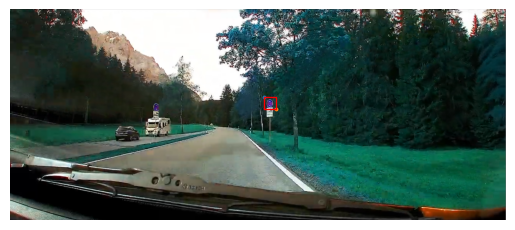

In [26]:
from matplotlib.patches import Rectangle

road_img = cv2.imread('road.png')

boxes = prediction[0].boxes.xyxy.cpu().data.numpy().astype(int)

plt.imshow(road_img)

for box in boxes:
    square_box, long = get_squered_box(box)

    
    plt.scatter(square_box[0],square_box[1], s=3)
    plt.scatter(square_box[2],square_box[3], s=3)
    
    plt.gca().add_patch(Rectangle((square_box[0],square_box[1]),long*2,long*2,
                        edgecolor='red',
                        facecolor='none',
                        lw=1))
    plt.axis('off')
plt.show()

In [39]:
boxes

array([[656, 230, 686, 255]])

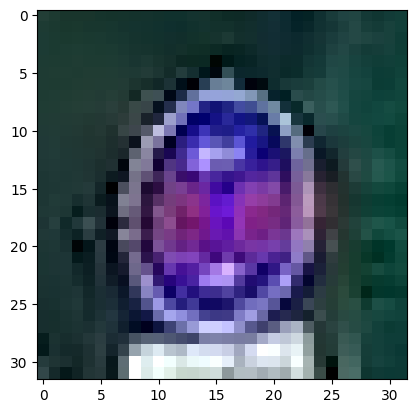

In [27]:
cropped_image = road_img[square_box[1]:square_box[3],square_box[0]:square_box[2]]
plt.imshow(cropped_image)
#plt.axis('off')
plt.show()

# Keras CNN classifier

In [29]:
import tensorflow as tf
# Load a model from a file
model = tf.keras.models.load_model("best_model.h5")

In [35]:
classes = { 
    0:'Speed limit (20km/h)',
    1:'Speed limit (30km/h)', 
    2:'Speed limit (50km/h)', 
    3:'Speed limit (60km/h)', 
    4:'Speed limit (70km/h)', 
    5:'Speed limit (80km/h)', 
    6:'End of speed limit (80km/h)', 
    7:'Speed limit (100km/h)', 
    8:'Speed limit (120km/h)', 
    9:'No passing', 
    10:'No passing veh over 3.5 tons', 
    11:'Right-of-way at intersection', 
    12:'Priority road', 
    13:'Yield', 
    14:'Stop', 
    15:'No vehicles', 
    16:'Veh > 3.5 tons prohibited', 
    17:'No entry', 
    18:'General caution', 
    19:'Dangerous curve left', 
    20:'Dangerous curve right', 
    21:'Double curve', 
    22:'Bumpy road', 
    23:'Slippery road', 
    24:'Road narrows on the right', 
    25:'Road work', 
    26:'Traffic signals', 
    27:'Pedestrians', 
    28:'Children crossing', 
    29:'Bicycles crossing', 
    30:'Beware of ice/snow',
    31:'Wild animals crossing', 
    32:'End speed + passing limits', 
    33:'Turn right ahead', 
    34:'Turn left ahead', 
    35:'Ahead only', 
    36:'Go straight or right', 
    37:'Go straight or left', 
    38:'Keep right', 
    39:'Keep left', 
    40:'Roundabout mandatory', 
    41:'End of no passing', 
    42:'End no passing veh > 3.5 tons'
}

In [32]:
image_size = (28,28)

image = tf.image.resize(cropped_image, image_size)
image = image / 255.0

roi_tensor = tf.expand_dims(image, axis=0)
# Evaluate the model on the data loader
trafficsign_preddiction = model.predict(roi_tensor)

1/1 [==============================] - 1s 821ms/step


In [36]:
classes.get(np.argmax(trafficsign_preddiction))

'Priority road'